# Hyperparameter tuning by randomized-search

In the previous notebook, we showed how to use a grid-search approach to
search for the best hyperparameters maximizing the generalization performance
of a predictive model.

However, a grid-search approach has limitations. It does not scale well when
the number of parameters to tune increases. Also, the grid imposes a
regularity during the search which might miss better parameter
values between two consecutive values on the grid.

In this notebook, we present a different method to tune hyperparameters called
randomized search.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/adult-census.csv"
adult_census = pd.read_csv(url)

We extract the column containing the target.

In [2]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information with `"education"` columns.

In [3]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

We create the same predictive pipeline as done for the grid-search section.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a randomized-search

With the `GridSearchCV` estimator, the parameters need to be specified
explicitly. We already mentioned that exploring a large number of values for
different parameters quickly becomes untractable.

Instead, we can randomly generate the parameter candidates. Indeed, such
approach avoids the regularity of the grid. Hence, adding more evaluations can
increase the resolution in each direction. This is the case in the frequent
situation where the choice of some hyperparameters is not very important, as
for the hyperparameter 2 in the figure below.

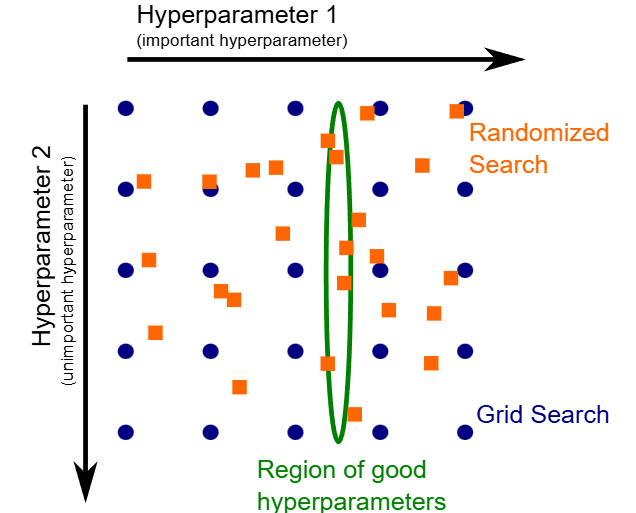

![Randomized vs grid search](../figures/grid_vs_random_search.svg)

Indeed, the number of evaluation points needs to be divided across the two
different hyperparameters. With a grid, the danger is that the region of good
hyperparameters may fall between lines of the grid. In the figure such region
is aligned with the grid given that hyperparameter 2 has a weak influence.
Rather, stochastic search samples the hyperparameter 1 independently from the
hyperparameter 2 and find the optimal region.

The `RandomizedSearchCV` class allows for such stochastic search. It is used
similarly to the `GridSearchCV` but the sampling distributions need to be
specified instead of the parameter values. For instance, we can draw
candidates using a log-uniform distribution because the parameters we are
interested in take positive values with a natural log scaling (.1 is as close
to 1 as 10 is).

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Random search (with <tt class="docutils literal">RandomizedSearchCV</tt>) is typically beneficial compared to
grid search (with <tt class="docutils literal">GridSearchCV</tt>) to optimize 3 or more hyperparameters.</p>
</div>

We now optimize 3 other parameters in addition to the ones we optimized in
the notebook presenting the `GridSearchCV`:

* `l2_regularization`: it corresponds to the strength of the regularization;
* `min_samples_leaf`: it corresponds to the minimum number of samples required
  in a leaf;
* `max_bins`: it corresponds to the maximum number of bins to construct the
  histograms.

We recall the meaning of the 2 remaining parameters:

* `learning_rate`: it corresponds to the speed at which the gradient-boosting
  corrects the residuals at each boosting iteration;
* `max_leaf_nodes`: it corresponds to the maximum number of leaves for each
  tree in the ensemble.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"><tt class="docutils literal">scipy.stats.loguniform</tt> can be used to generate floating numbers. To generate
random values for integer-valued parameters (e.g. <tt class="docutils literal">min_samples_leaf</tt>) we can
adapt it as follows:</p>
</div>

In [7]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Now, we can define the randomized search using the different distributions.
Executing 10 iterations of 5-fold cross-validation for random parametrizations
of this model on this dataset can take from 10 seconds to several minutes,
depending on the speed of the host computer and the number of available
processors.

In [9]:
# To stop the warning
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Replace '4' with the number of cores you want to use

In [10]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 5min 4s
Wall time: 31.6 s


c:\Users\npigeon1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              HistGradientBoostingC...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012A8790D8C0>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x0000012A87832330>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x0000012A8783F6F0>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x0000012A8783FBB0>},
                   verbose=1)

Then, we can compute the accuracy score on the test set.

In [11]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is {accuracy:.2f}")

The test accuracy score of the best model is 0.88


In [12]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': np.float64(49.32674590836441),
 'classifier__learning_rate': np.float64(0.43008031665501084),
 'classifier__max_bins': np.int64(150),
 'classifier__max_leaf_nodes': np.int64(125),
 'classifier__min_samples_leaf': np.int64(1)}


We can inspect the results using the attributes `cv_results` as we did
previously.

In [13]:
# get the parameter names
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)


def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
6,49.326746,0.430080,125,1,150,0.865142,0.002715,1
5,534.659885,1.073940,9,3,104,0.862439,0.002139,2
9,0.000048,0.278246,7,60,19,0.853949,0.003616,3
7,0.000090,0.019996,13,1,49,0.847179,0.001835,4
1,712.960771,1.314497,41,5,5,0.830117,0.003274,5
8,0.000059,0.115280,2,31,10,0.813164,0.002115,6
0,0.000128,0.009331,2,2,9,0.758947,0.000013,7
3,461.959777,0.012000,221,1,118,0.758947,0.000013,7
4,0.004387,0.004383,4,3,43,0.758947,0.000013,7
2,2.346464,5.191086,24,29,203,0.706695,0.104699,10


Keep in mind that tuning is limited by the number of different combinations of
parameters that are scored by the randomized search. In fact, there might be
other sets of parameters leading to similar or better generalization
performances but that were not tested in the search. In practice, a randomized
hyperparameter search is usually run with a large number of iterations. In
order to avoid the computation cost and still make a decent analysis, we load
the results obtained from a similar search with 500 iterations.

In [16]:
model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=500,
    n_jobs=2, cv=5)
model_random_search.fit(data_train, target_train)
cv_results =  pd.DataFrame(model_random_search.cv_results_)


In [17]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_bins,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.384735,0.028353,0.063872,0.011545,0.003643,0.006954,136,7,46,{'classifier__l2_regularization': 0.0036426926...,0.811110,0.813404,0.807535,0.812039,0.813404,0.811498,0.002164,220
1,0.165280,0.029995,0.027261,0.003329,0.000068,4.713986,2,66,7,{'classifier__l2_regularization': 6.7626464586...,0.730722,0.682910,0.657658,0.719219,0.733279,0.704758,0.029639,448
2,0.508922,0.033357,0.073756,0.004274,46.346609,0.011492,86,18,5,{'classifier__l2_regularization': 46.346609208...,0.841136,0.828692,0.836609,0.832651,0.834152,0.834648,0.004139,161
3,0.306325,0.002655,0.047008,0.003410,0.004376,0.036193,115,3,10,{'classifier__l2_regularization': 0.0043758112...,0.819026,0.813814,0.816271,0.813268,0.815179,0.815511,0.002047,210
4,0.277053,0.059194,0.044080,0.013675,11.866169,0.547657,5,7,2,{'classifier__l2_regularization': 11.866168557...,0.828170,0.827191,0.834562,0.827600,0.831286,0.829762,0.002799,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.431193,0.045479,0.066768,0.003767,2.561853,0.284833,145,10,33,{'classifier__l2_regularization': 2.5618533934...,0.866521,0.871963,0.869779,0.866639,0.871553,0.869291,0.002332,4
496,0.532977,0.013556,0.079705,0.002277,0.000472,0.039836,78,16,19,{'classifier__l2_regularization': 0.0004720387...,0.853692,0.858995,0.857221,0.852307,0.856675,0.855778,0.002435,50
497,0.862595,0.008430,0.087274,0.005320,0.000125,0.013261,6,68,13,{'classifier__l2_regularization': 0.0001254912...,0.823529,0.823642,0.821867,0.824051,0.823232,0.823264,0.000746,195
498,0.138513,0.004952,0.026256,0.003547,13.797654,9.185270,13,7,1,{'classifier__l2_regularization': 13.797654129...,0.741777,0.498362,0.596233,0.737101,0.547775,0.624249,0.099024,478


In [18]:
cv_results.to_csv("random_search_results.csv")

In [20]:
cv_results = pd.read_csv(
    "random_search_results.csv", index_col=0
)

(
    cv_results[column_results]
    .rename(shorten_param, axis=1)
    .sort_values("mean_test_score", ascending=False)
)

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
447,0.151984,0.217930,33,2,242,0.871257,0.002692,1
467,0.896884,0.256908,43,3,186,0.870274,0.003050,2
23,0.047479,0.228487,21,2,183,0.870219,0.001907,3
495,2.561853,0.284833,10,33,145,0.869291,0.002332,4
327,0.000004,0.156587,49,67,167,0.868745,0.002757,5
...,...,...,...,...,...,...,...,...
214,0.873433,5.677729,3,61,4,0.284813,0.006026,496
59,0.000514,4.475210,3,5,229,0.283476,0.005123,497
238,0.001297,5.235163,3,83,5,0.283476,0.005123,497
244,0.001553,7.906477,4,1,28,0.283367,0.005104,499


In this case the top performing models have test scores with a high overlap
between each other, meaning that indeed, the set of parameters leading to the
best generalization performance is not unique.


In this notebook, we saw how a randomized search offers a valuable alternative
to grid-search when the number of hyperparameters to tune is more than two. It
also alleviates the regularity imposed by the grid that might be problematic
sometimes.

In the following, we will see how to use interactive plotting tools to explore
the results of large hyperparameter search sessions and gain some insights on
range of parameter values that lead to the highest performing models and how
different hyperparameter are coupled or not.